In [1]:
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 7)

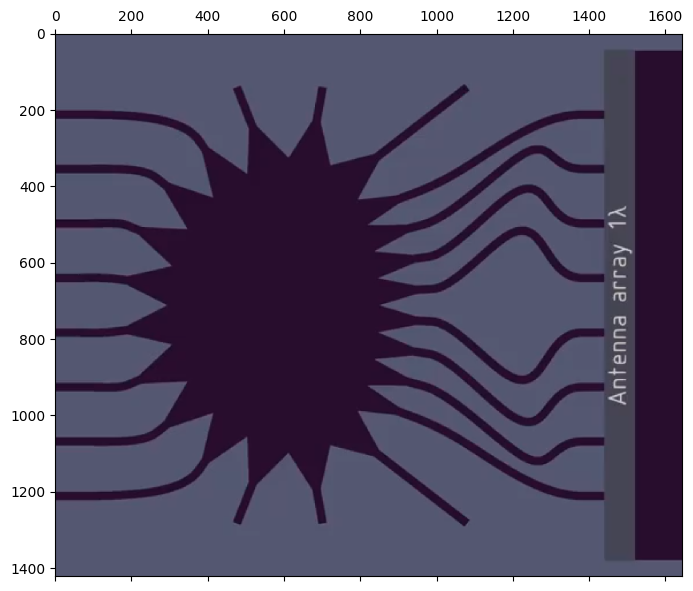

In [2]:
# This is a screencap of the video from Lukas Henkel's tweet
# cf. https://x.com/QVHenkel/status/1798898028423610748
screencap = np.array(Image.open('screencap.png'))
plt.matshow(screencap)


Final simulation shape: (474, 882)


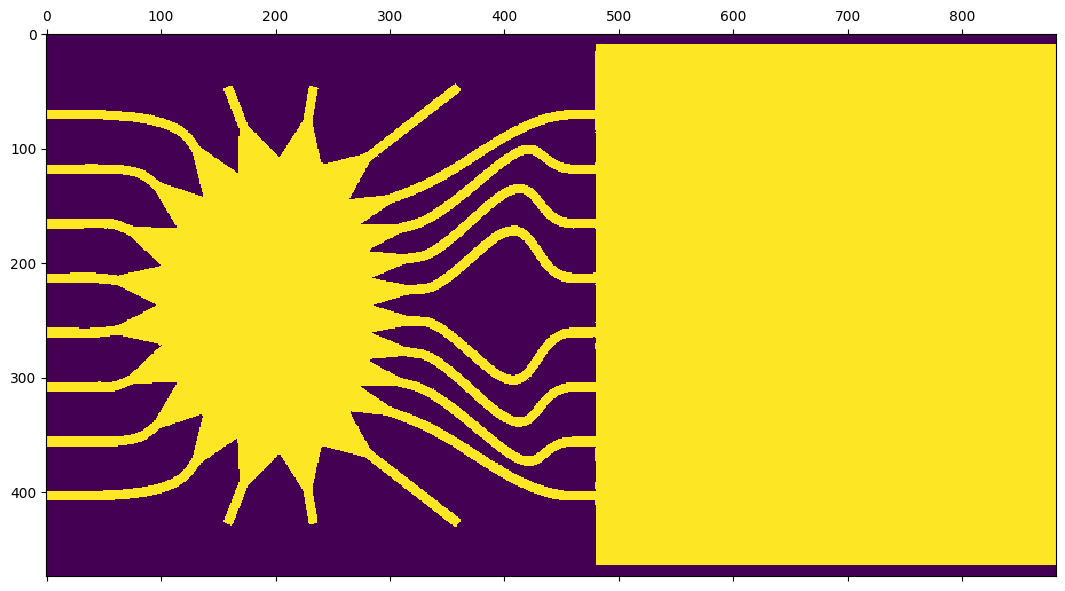

In [87]:
# We extract the geometry from the screencap.
background_color = screencap[:100, :100].mean(axis=(0, 1))
distance_from_background_color = np.linalg.norm(screencap - background_color, axis=2)
rotman_lens_big = distance_from_background_color >= 20
# We extend the array to see the far-field behavior.
rotman_lens_big = np.concatenate([
    rotman_lens_big,
    np.zeros((rotman_lens_big.shape[0], 1000), dtype=bool),
], axis=1)
# Fix up the part starting around the text.
rotman_lens_big[30:-30, 1440:] = 1
rotman_lens = rotman_lens_big[1::3, 1::3]
rotman_lens_gpu = torch.tensor(rotman_lens, dtype=torch.float32).cuda()
print("Final simulation shape:", rotman_lens.shape)
plt.matshow(rotman_lens)

/tmp/ipykernel_666423/2733338852.py:9: RuntimeWarning: divide by zero encountered in divide
  rescaling = np.where((interior_count == 0) | rotman_lens, 0, 1 / interior_count)


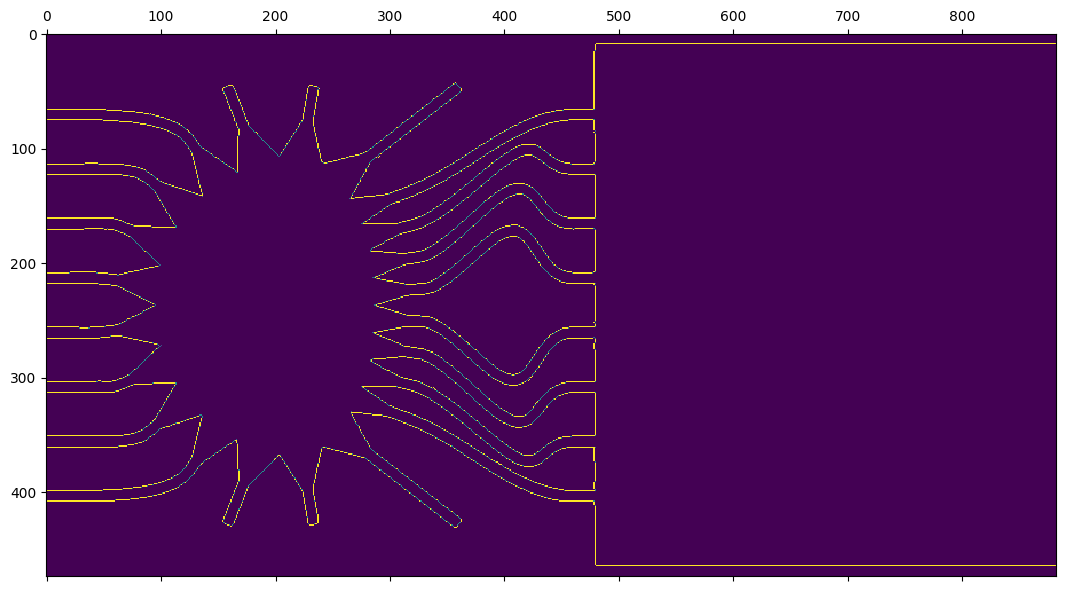

In [94]:
# We are going to copy interior values to the boundary, to produce reflections, and
# avoid dissipation. In order to do this, we want a rescaling factor that's inversely
# proportional to the number of interior neighbors for each point on the boundary.
interior_count = np.zeros_like(rotman_lens, dtype=np.float32)
interior_count[1:, :] += rotman_lens[:-1, :]
interior_count[:-1, :] += rotman_lens[1:, :]
interior_count[:, 1:] += rotman_lens[:, :-1]
interior_count[:, :-1] += rotman_lens[:, 1:]
rescaling = np.where((interior_count == 0) | rotman_lens, 0, 1 / interior_count)
plt.matshow(rescaling)
rescaling_gpu = torch.tensor(rescaling, dtype=torch.float32).cuda()

In [136]:
# We write the simplest FDTD `u'' = -laplacian u` PDE solver imaginable.
interior_2d = slice(1, -1), slice(1, -1)

def laplacian_2d(a):
    b = torch.zeros_like(a)
    b[interior_2d] = 0.25 * (
        a[:-2, 1:-1] + a[2:, 1:-1]
        + a[1:-1, :-2] + a[1:-1, 2:]
        - 4*a[interior_2d]
    )
    return b

def simulate_exitation(y_lo, y_hi, excite_f, dt, k, total_time):
    u = torch.zeros_like(rotman_lens_gpu, dtype=torch.float32)
    udot = torch.zeros_like(rotman_lens_gpu, dtype=torch.float32)
    steps = int(total_time / dt)
    for t in range(steps):
        # Apply exictation at the left edge.
        u[y_lo:y_hi, :3] = math.sin(2 * math.pi * dt * t * excite_f)
        # Update u using u'
        u += dt * udot
        # Enforce boundary conditions by setting each point
        # on the boundary to an average of interior values.
        lens_only_u = u * rotman_lens_gpu
        smoothed_values = torch.zeros_like(lens_only_u)
        smoothed_values[1:, :] += lens_only_u[:-1, :]
        smoothed_values[:-1, :] += lens_only_u[1:, :]
        smoothed_values[:, 1:] += lens_only_u[:, :-1]
        smoothed_values[:, :-1] += lens_only_u[:, 1:]
        smoothed_values *= rescaling_gpu
        # Update u' by computing u''
        udotdot = rotman_lens_gpu * laplacian_2d(u * rotman_lens_gpu + smoothed_values)
        udot += k * dt * udotdot
    u[y_lo:y_hi, :10] = 0
    return u.cpu().numpy()

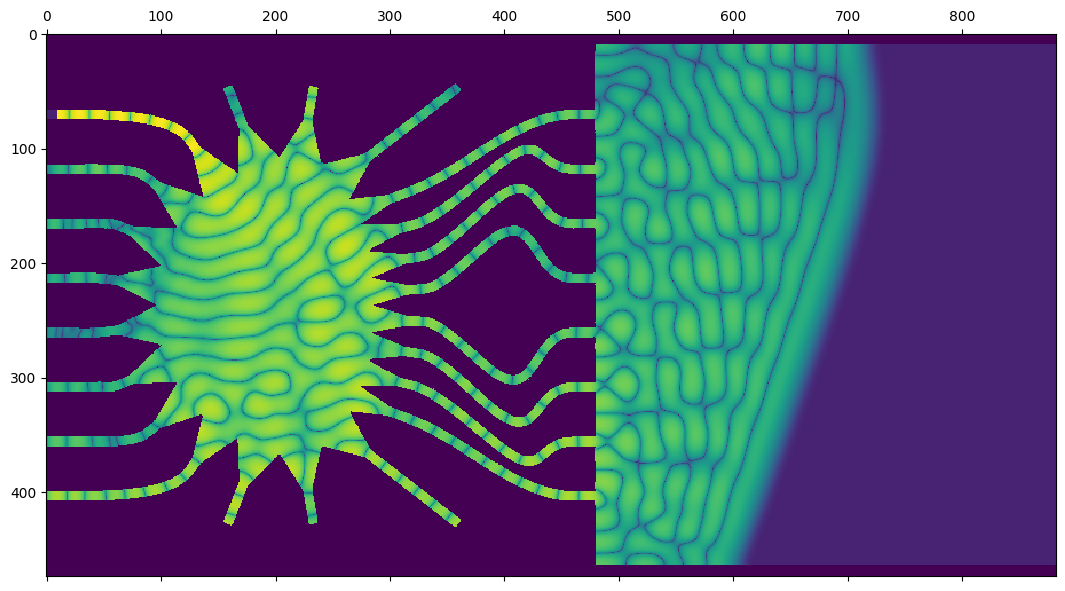

In [137]:
u = simulate_exitation(50, 100, excite_f=0.014, dt=0.1, k=1.0, total_time=1500.0)
u = np.log(1e-4 + np.abs(u))
u += rotman_lens
plt.matshow(u)

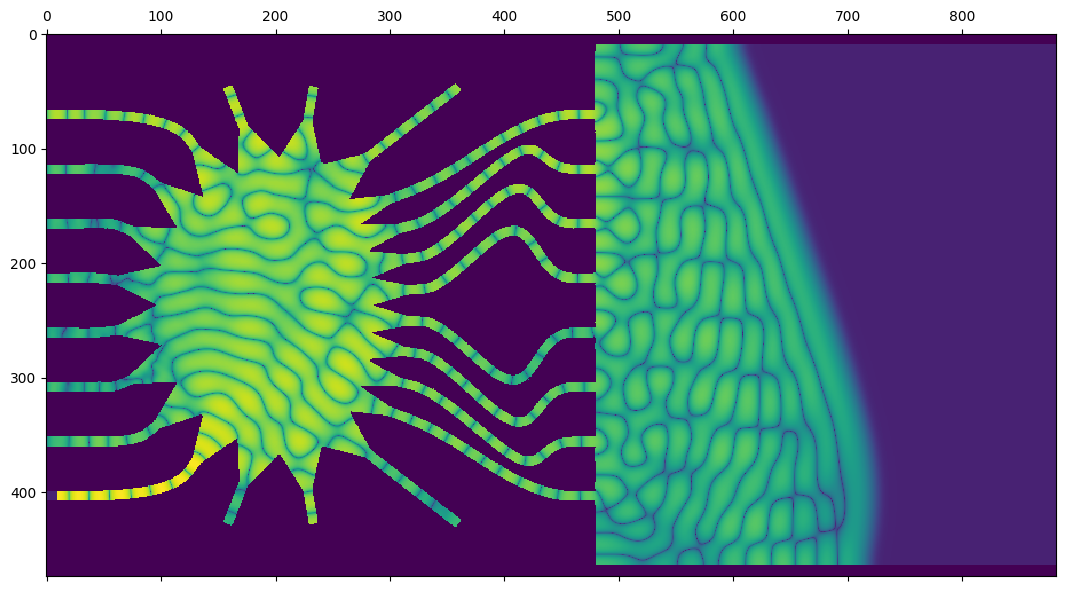

In [138]:
u = simulate_exitation(390, 420, excite_f=0.014, dt=0.1, k=1.0, total_time=1500.0)
u = np.log(1e-4 + np.abs(u))
u += rotman_lens
plt.matshow(u)

In [141]:
# We now produce a video of the simulation, for Twitter.
import subprocess

def simulate_exitation_video(y_lo, y_hi, excite_f, dt, k, total_time):
    ffmpeg_process = subprocess.Popen(
        [
            'ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-s', f'{rotman_lens.shape[1]}x{rotman_lens.shape[0]}',
            '-pix_fmt', 'rgb24',
            '-r', '60',
            '-i', '-',
            '-an',
            '-c:v', 'libx265',
            '-crf', '20',
            'output.mkv'
        ],
        stdin=subprocess.PIPE,
    )

    frame = np.zeros(shape=rotman_lens.shape + (3,), dtype=np.uint8)
    u = torch.zeros_like(rotman_lens_gpu, dtype=torch.float32)
    udot = torch.zeros_like(rotman_lens_gpu, dtype=torch.float32)
    steps = int(total_time / dt)
    for t in range(steps):
        # Apply exictation at the left edge.
        u[y_lo:y_hi, :3] = math.sin(2 * math.pi * dt * t * excite_f)
        # Update u using u'
        u += dt * udot
        # Enforce boundary conditions by setting each point
        # on the boundary to an average of interior values.
        lens_only_u = u * rotman_lens_gpu
        smoothed_values = torch.zeros_like(lens_only_u)
        smoothed_values[1:, :] += lens_only_u[:-1, :]
        smoothed_values[:-1, :] += lens_only_u[1:, :]
        smoothed_values[:, 1:] += lens_only_u[:, :-1]
        smoothed_values[:, :-1] += lens_only_u[:, 1:]
        smoothed_values *= rescaling_gpu
        # Update u' by computing u''
        udotdot = rotman_lens_gpu * laplacian_2d(u * rotman_lens_gpu + smoothed_values)
        udot += k * dt * udotdot
        if t % 20 == 0:
            to_render = np.log(1e-2 + np.abs(rotman_lens * u.cpu().numpy()))
            #to_render += rotman_lens
            lo = math.log(1e-2)
            hi = math.log(1)
            frame[:, :, 0] = np.clip(200 * (to_render - lo) / (hi - lo), 0, 200)
            frame[:, :, 1] = frame[:, :, 0]
            frame[:, :, 2] = frame[:, :, 0]
            frame[:, :, 0] += 15
            frame[:, :, 1] += 10
            frame[:, :, 2] += 20
            m = rotman_lens.astype(np.uint8)
            frame[:, :, 0] += m * 25
            frame[:, :, 1] += m * 25
            frame[:, :, 2] += m * 35
            #frame[:, :, 1] = rotman_lens * 255
            ffmpeg_process.stdin.write(frame.tobytes())
    ffmpeg_process.stdin.close()
    ffmpeg_process.wait()

In [142]:
simulate_exitation_video(50, 100, excite_f=0.014, dt=0.1, k=1.0, total_time=2000.0)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena